In [0]:
!pip install tensorflow-hub
!pip install numpy==1.16.1
#!pip install keras==2.1.2
!pip install git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter
#!pip install sortedcontainer

from __future__ import print_function
import math
import pickle
import json
import os

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras import layers 
from keras import metrics
from keras.datasets import reuters
from keras.preprocessing import text

from sklearn.model_selection import train_test_split

from cmu.syllables_cmu import syllables as word2sylls
print(word2sylls['therefore'])

# cut texts after this number of words
# (among top max_features most common words)
max_features = 16000
# longest output sentence
maxlen = 5
batch_size = 32

!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/haiku_5_same.txt
haiku_data = 'haiku_5_same.txt'
haiku_text = []
with open(haiku_data) as f:
    for line in f.readlines():
        haiku_text.append(line.split('\t')[0])


Using TensorFlow backend.


['DH EH R', 'F AO R']
File ‘haiku_5_same.txt’ already there; not retrieving.



In [0]:
def tokenizer_from_json(json_string):
    """Parses a JSON tokenizer configuration file and returns a
    tokenizer instance.
    # Arguments
        json_string: JSON string encoding a tokenizer configuration.
    # Returns
        A Keras Tokenizer instance
    """
    tokenizer_config = json.loads(json_string)
    config = tokenizer_config.get('config')

    word_counts = json.loads(config.pop('word_counts'))
    word_docs = json.loads(config.pop('word_docs'))
    index_docs = json.loads(config.pop('index_docs'))
    # Integer indexing gets converted to strings with json.dumps()
    index_docs = {int(k): v for k, v in index_docs.items()}
    index_word = json.loads(config.pop('index_word'))
    index_word = {int(k): v for k, v in index_word.items()}
    word_index = json.loads(config.pop('word_index'))

    tokenizer = text.Tokenizer(**config)
    tokenizer.word_counts = word_counts
    tokenizer.word_docs = word_docs
    tokenizer.index_docs = index_docs
    tokenizer.word_index = word_index
    tokenizer.index_word = index_word

    return tokenizer

In [0]:
!date
!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/haiku_5_same.txt
!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/toki_cmu.json
haiku_data = 'haiku_5_same.txt'
toki_file = 'toki_cmu.json'
haiku_text = []
with open(haiku_data) as f:
    for line in f.readlines():
        haiku_text.append(line.split('\t')[0])
!date
big_sylls = set()
for index, word in enumerate(word2sylls):
    sylls = word2sylls[word]
    for syll in sylls:
        syll = syll.replace(' ', '').lower()
        big_sylls.add(syll)

syll2idx = {}
for index, syll in enumerate(big_sylls):
    syll2idx[syll] = index
idx2syll = [0] * len(syll2idx)
for index, syll in enumerate(syll2idx):
    idx2syll[index] = syll

print(syll2idx['dhehr'], idx2syll[1])
print('# features: ', len(idx2syll))
!date
data_all = np.zeros((len(haiku_text), 5), dtype='int32')
for i in range(len(haiku_text)):    
    seq = text.text_to_word_sequence(haiku_text[i])
    sylls = []
    for word in seq:
        if word in word2sylls:
            for syll in word2sylls[word]:
                sylls.append(syll.replace(' ', '').lower())
    
    for j in range(5):
        if len(sylls) > j:
            data_all[i][j] = syll2idx[sylls[j]]
    if i == 0:
        print(haiku_text[i])
        print(sylls)
        print(data_all[i])

!date   
print(haiku_text[0])
print(data_all[0])
print(haiku_text[2999])
print(data_all[2999])
!date
#(x_train, x_test, y_train, y_test) = train_test_split(haiku_text, data_all)


Thu Jun 27 21:56:32 UTC 2019
File ‘haiku_5_same.txt’ already there; not retrieving.

File ‘toki_cmu.json’ already there; not retrieving.

Thu Jun 27 21:56:35 UTC 2019
12668 aemk
# features:  15086
Thu Jun 27 21:56:36 UTC 2019
a abandon church
['ah', 'ah', 'baen', 'dahn', 'cherch']
[6763 6763 9255  124 7555]
Thu Jun 27 21:56:39 UTC 2019
a abandon church
[6763 6763 9255  124 7555]
a cardboard cutout
[ 6763 14984  5325  6329 11795]
Thu Jun 27 21:56:40 UTC 2019


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]



In [0]:
(x_train, x_test, y_train, y_test) = train_test_split(haiku_text, data_all)
print(x_train[0], y_train[0])
print(x_test[0], y_test[0])
print(x_train[-1], y_train[-1])
print(x_test[-1], y_test[-1])

def get_lstm(size, return_sequences=True):
    return layers.CuDNNLSTM(size, return_sequences=return_sequences)

def pack(indexes, maxlen):
    print(type(indexes))
    print(type(indexes[0]))
    print(type(indexes[0][0]))
    ilen = len(indexes)
    out = np.zeros((ilen, maxlen))
    for i in range(ilen):
        for j in range(len(indexes[i])):
            if j >= maxlen:
                continue
            #print(i,j, len(indexes[i]))  
            if len(indexes[i][j]) > 0:
                out[i][j] = indexes[i][j][0]
    return out
    
print('Pad sequences (samples x time)')
x_train = np.array(x_train)
x_test = np.array(x_test)
#y_train = np.expand_dims(pack(y_train, maxlen), -1)
#y_test = np.expand_dims(pack(y_test, maxlen), -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_test[0][0])



dressed in a blue gown [ 5305  5219  6763  2284 10067]
island counter top [ 5569  4746 13831 13197 11062]
toilet paper rolls [ 8802  8122  5662  5108 14488]
perform in the race [ 5108 13645  5219 10473  6511]
Pad sequences (samples x time)
x_train shape: (71716,)
x_test shape: (23906,)
y_train shape: (71716, 5, 1)
y_test shape: (23906, 5, 1)
[5569]


In [0]:
# https://github.com/philipperemy/keras-snail-attention/blob/master/attention.py
class AttentionBlock(layers.Layer):

    def __init__(self, dims, k_size, v_size, seq_len=None, **kwargs):
        self.k_size = k_size
        self.seq_len = seq_len
        self.v_size = v_size
        self.dims = dims
        self.sqrt_k = math.sqrt(k_size)
        self.keys_fc = None
        self.queries_fc = None
        self.values_fc = None
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # https://stackoverflow.com/questions/54194724/how-to-use-keras-layers-in-custom-keras-layer
        self.keys_fc = layers.Dense(self.k_size)
        self.keys_fc.build((None, self.dims))
        self._trainable_weights.extend(self.keys_fc.trainable_weights)

        self.queries_fc = layers.Dense(self.k_size)
        self.queries_fc.build((None, self.dims))
        self._trainable_weights.extend(self.queries_fc.trainable_weights)

        self.values_fc = layers.Dense(self.v_size)
        self.values_fc.build((None, self.dims))
        self._trainable_weights.extend(self.values_fc.trainable_weights)

    def call(self, inputs, **kwargs):
        # check that the implementation matches exactly py torch.
        keys = self.keys_fc(inputs)
        queries = self.queries_fc(inputs)
        values = self.values_fc(inputs)
        logits = K.batch_dot(queries, K.permute_dimensions(keys, (0, 2, 1)))
        mask = K.ones_like(logits) * np.triu((-np.inf) * np.ones(logits.shape.as_list()[1:]), k=1)
        logits = mask + logits
        probs = layers.Softmax(axis=-1)(logits / self.sqrt_k)
        read = K.batch_dot(probs, values)
        output = K.concatenate([inputs, read], axis=-1)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] += self.v_size
        return tuple(output_shape)



In [0]:
def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=5):
    original_shape = K.shape(y_true)
    y_true = K.reshape(y_true, (-1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[-1]))
    top_k = K.in_top_k(y_pred, K.cast(K.max(y_true, axis=-1), 'int32'), k)
    return K.reshape(top_k, original_shape[:-1])

def sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5):
    original_shape = K.shape(y_true)
    y_true = K.reshape(y_true, (-1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[-1]))
    top_k = K.in_top_k(y_pred, K.cast(K.max(y_true, axis=-1), 'int32'), k)
    perfect = K.min(K.cast(top_k, 'int32'), axis=-1)
    return perfect #K.expand_dims(perfect, axis=-1)

def sparse(y_true, y_pred):
    return sparse_categorical_accuracy(y_true, y_pred)
def sparse1(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=1)
def perfect(y_true, y_pred):
    return sparse_categorical_accuracy_per_sequence(y_true, y_pred)
def perfect1(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=1)
def sparse5(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=5)
def perfect5(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5)
def fscore(y_true, y_pred):
    recall = K.mean(sparse_categorical_accuracy(y_true, y_pred))
    precision = K.mean(sparse_categorical_accuracy_per_sequence(y_true, y_pred))
    return 2 * ((recall * precision)/(recall + precision))


units_k=embed_size
units_v=embed_size//3
units=512

metric_list = [sparse, sparse1, perfect, perfect1, sparse5, perfect5]
metric_names = ['sparse', 'sparse1', 'perfect', 'perfect1', 'sparse5', 'perfect5']

input_text = layers.Input(shape=(1,), dtype=tf.string)
x = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,), name='TF-Hub')(input_text)
x = layers.RepeatVector(maxlen)(x)
if False:
    #x = layers.Dropout(0.1)(x)
    x = AttentionBlock(embed_size, k_size=units_k, v_size=units_v)(x)
x = get_lstm(units, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
# with 0.1, perfect peaked at 40 epochs
x = layers.Dense(max_features, activation='softmax')(x)
#x = layers.Reshape((-1, max_features * maxlen))(x)


model = Model(inputs=[input_text], outputs=x)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=metric_list)
model.summary()

# try using different optimizers and different optimizer configs

print('Train...')
history = None
use_saved_model=False
if not use_saved_model or not os.path.exists('./model.h5'):
  with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=2,
          validation_data=[x_test, y_test])
    model.save_weights('./model.h5')


W0627 21:56:42.921517 140591835309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 21:56:42.922987 140591835309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 21:56:44.332704 140591835309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 21:56:44.945052 140591835309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0627 21:56:44.955622 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
TF-Hub (Lambda)              (None, 512)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 5, 512)            2101248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 16000)          8208000   
Total params: 10,309,248
Trainable params: 10,309,248
Non-trainable params: 0
________________________________________________________________

W0627 21:56:48.094377 140591835309952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 71716 samples, validate on 23906 samples
Epoch 1/50
 - 91s - loss: 4.6094 - sparse: 0.2368 - sparse1: 0.2368 - perfect: 0.0035 - perfect1: 0.0000e+00 - sparse5: 0.4214 - perfect5: 0.0000e+00 - val_loss: 3.2398 - val_sparse: 0.3952 - val_sparse1: 0.3952 - val_perfect: 0.0220 - val_perfect1: 0.0000e+00 - val_sparse5: 0.6248 - val_perfect5: 0.0000e+00
Epoch 2/50
 - 87s - loss: 2.9758 - sparse: 0.4260 - sparse1: 0.4260 - perfect: 0.0349 - perfect1: 0.0000e+00 - sparse5: 0.6580 - perfect5: 0.0000e+00 - val_loss: 2.5235 - val_sparse: 0.5026 - val_sparse1: 0.5026 - val_perfect: 0.0737 - val_perfect1: 0.0000e+00 - val_sparse5: 0.7261 - val_perfect5: 0.0000e+00
Epoch 3/50
 - 86s - loss: 2.4466 - sparse: 0.5008 - sparse1: 0.5008 - perfect: 0.0741 - perfect1: 0.0000e+00 - sparse5: 0.7314 - perfect5: 0.0000e+00 - val_loss: 2.1979 - val_sparse: 0.5556 - val_sparse1: 0.5556 - val_perfect: 0.1190 - val_perfect1: 0.0000e+00 - val_sparse5: 0.7725 - val_perfect5: 0.0000e+00
Epoch 4/50
 - 85s - 

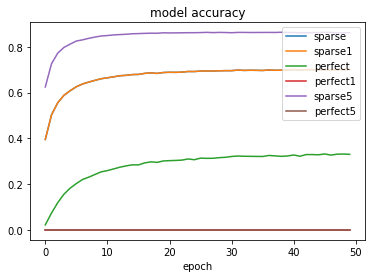

In [0]:

if history != None:
  # summarize history for accuracy
  for m in metric_names:
      plt.plot(history.history['val_' + m])
  plt.title('model accuracy')
  plt.xlabel('epoch')
  plt.legend(metric_names, loc='upper right')
  plt.show()

In [0]:
x_short = x_test[0:1000]
y_short = y_test[0:1000]
predicts = None

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  #eval = model.evaluate(x_test, y_test)
  #print('model.evaluate on val holdout: ' ,model.metrics_names, eval)
  print('history: ', history)
  predicts = model.predict(x_short, batch_size=32)
  print('shape: {}'.format(predicts.shape))

print(len(predicts[0]))
print(len(predicts[0][0]))
print(predicts[0])

history:  <keras.callbacks.History object at 0x7fddb1236dd8>


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fddbb138e10>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


shape: (1000, 5, 16000)
5
16000
[[7.3998235e-05 3.1968710e-08 7.8295907e-06 ... 3.1912968e-08
  3.1109796e-08 3.1769822e-08]
 [1.9782770e-04 3.4644457e-10 2.2502853e-08 ... 3.2651468e-10
  3.3602326e-10 3.3877956e-10]
 [8.7786204e-04 8.1113383e-09 7.1187264e-05 ... 7.9476870e-09
  8.1808516e-09 8.2170706e-09]
 [4.2917053e-03 6.4278849e-10 8.9306632e-06 ... 6.0054517e-10
  6.1138261e-10 6.2123207e-10]
 [6.7159700e-01 1.6881557e-12 1.4885356e-06 ... 1.7063552e-12
  1.7310891e-12 1.6589588e-12]]


In [0]:
def maxindx(pred):
    maxi=-1
    maxv=-1.0
    for x in range(len(pred)):
        if pred[x] > maxv:
            maxv = pred[x]
            maxi = x
    return (maxi, maxv)

def match(data, prediction):
    good = 0
    total = 0
    for i in range(len(data)):
        #print(data[i], np.argmax(prediction[i]))
        if data[i] == np.argmax(prediction[i]):
            good += 1
        total += 1
    #print('{}, {}'.format(good, total))
    if (total == 0):
        return 0
    return good / total

parallel = 0.0
serial = 0.0
total = 0
for n in range(len(y_short)):
    #print(len(short[n]))
    check = match(y_short[n], predicts[n])
    parallel += check
    if check > 0.9999:
        serial += 1
    total += 1

print('Parallel, serial: ', parallel / total, serial / total)


Parallel, serial:  0.710599999999998 0.34


In [0]:
!wget -nc https://raw.githubusercontent.com/LanceNorskog/test_data/master/haiku_5.txt
!rm -f toki_cmu.json
!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/toki_cmu.json
import collections 

big_data_file = 'haiku_5.txt'
big_text = []
big_haiku = []
big_sylls = set()
for index, word in enumerate(word2sylls):
    sylls = word2sylls[word]
    for syll in sylls:
        syll = syll.replace(' ', '').lower()
        big_sylls.add(syll)

    
with open(big_data_file) as f:
    for line in f.readlines():
        big_text.append(line.strip().split('\t')[0])
        big_haiku.append(line.strip().split('\t')[1])
        
big_data = np.zeros((len(big_text), maxlen, 1), dtype='int32')
for i in range(len(big_text)):    
    seq = text.text_to_word_sequence(big_haiku[i])
    sylls = []
    for word in seq:
        if word in word2sylls:
            for syll in word2sylls[word]:
                sylls.append(syll.replace(' ', '').lower())
    for j in range(5):
        if len(sylls) > j:
            big_data[i][j][0] = syll2idx[sylls[j]]
    if i == 0:
        print(big_haiku[i])
        print(sylls)
        print(big_data[i])
   
print('Full length clauses: ', len(big_text))
big_text = np.array(big_text)

def printhistory(history):
    print(metrics_names.join(','))
    out = ''
    for m in metrics_names:
        out += history[m][0] + ','
    print(out[0:-1])

File ‘haiku_5.txt’ already there; not retrieving.

--2019-06-28 01:51:33--  https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/toki_cmu.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 357359 (349K) [text/plain]
Saving to: ‘toki_cmu.json’

toki_cmu.json       100%[===================>] 348.98K  --.-KB/s    in 0.05s   

2019-06-28 01:51:33 (6.83 MB/s) - ‘toki_cmu.json’ saved [357359/357359]

backyards to stockyards
['baek', 'yaardz', 'tuw', 'staak', 'yaardz']
[[ 6862]
 [14341]
 [ 4364]
 [ 7884]
 [14341]]
Full length clauses:  77203


In [0]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  eval_small = model.evaluate(np.array(big_haiku), big_data)
  print('model.evaluate on haiku clauses: ' ,model.metrics_names, eval_small)
  print('history: ', history)
  eval_big = model.evaluate(np.array(big_text), big_data)
  print('model.evaluate on long clauses: ' ,model.metrics_names, eval_big)
  print('history: ', history)
  biglen = len(big_text)
  #for i in range(0, len(big_text), batch_size):
  #  predicts = model.predict(big_text[i:i + batch_size], batch_size=batch_size)
  #  print('shape: {}'.format(predicts.shape))


  160/77203 [..............................] - ETA: 7:17 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fdd4fad9ef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


77203/77203 [==============================] - 52s 678us/step
model.evaluate on haiku clauses:  ['loss', 'sparse', 'sparse1', 'perfect', 'perfect1', 'sparse5', 'perfect5'] [0.39229551194467754, 0.9185964275849859, 0.9185964275849859, 0.7514992940627069, 0.02984339986788078, 0.9731875691959194, 0.19381371190238722]
history:  <keras.callbacks.History object at 0x7fddb1236dd8>
77203/77203 [==============================] - 54s 706us/step
model.evaluate on long clauses:  ['loss', 'sparse', 'sparse1', 'perfect', 'perfect1', 'sparse5', 'perfect5'] [4.826785261340134, 0.45996917251441005, 0.45996917251441005, 0.27071486859550553, 0.0, 0.6165641231129099, 0.0]
history:  <keras.callbacks.History object at 0x7fddb1236dd8>


In [0]:
def printhistory(history):
    print(','.join(model.metrics_names))
    out = ''
    for i in range(len(model.metrics_names)):
        out += str(history[i]) + ','
    print(out[0:-1])
    
printhistory(eval_small)
printhistory(eval_big)

loss,sparse,sparse1,perfect,perfect1,sparse5,perfect5
0.39229551194467754,0.9185964275849859,0.9185964275849859,0.7514992940627069,0.02984339986788078,0.9731875691959194,0.19381371190238722
loss,sparse,sparse1,perfect,perfect1,sparse5,perfect5
4.826785261340134,0.45996917251441005,0.45996917251441005,0.27071486859550553,0.0,0.6165641231129099,0.0


In [0]:
def report(data, prediction):
    def match(data, prediction):
        good = 0
        top5 = 0
        count = 0
        for i in range(len(data)):
            topind = np.argsort(prediction[i])
            if data[i][0] == topind[-1]:
                good += 1
            topind = topind[-5:len(topind)]
            for j in range(5):
                if data[i][0] == topind[j]:
                    top5 += 1
                    break
            count += 1
        return (good, top5, count)

    _sparse = 0.0
    _perfect = 0.0
    _sparse5 = 0.0
    _perfect5 = 0.0
    _total = 0
    for n in range(len(data)):
        #print(len(short[n]))
        (good, top5, count) = match(data[n], predicts[n])
        if count == 0:
            continue
        _sparse += good/count
        _sparse5 += top5/count
        if good == count:
            _perfect += 1  
        if top5 == count:
            _perfect5 += 1
        _total += 1
    return {'sparse':_sparse/_total, 'perfect': _perfect/_total, 'sparse5': _sparse5/_total, 'perfect5': _perfect5/_total}


In [0]:
bigbatch = batch_size * 32
big_text = np.array(big_text)
big_haiku = np.array(big_haiku)
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(big_haiku[0: bigbatch], batch_size=bigbatch)
  rep = report(big_data[0: bigbatch], predicts)
  print("short {}".format(rep))
  biglen = len(big_text)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(big_haiku[i:i + bigbatch], batch_size=bigbatch)
    rep = report(big_data[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
